In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

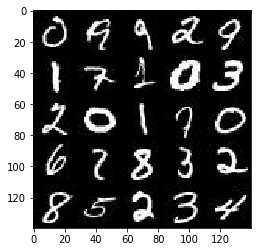

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

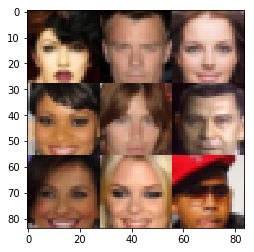

In [3]:
show_n_images = 15

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real=tf.placeholder(tf.float32,(None,image_width,image_height,image_channels),name='input_real')
    input_z=tf.placeholder(tf.float32,(None,z_dim),name='input_z')
    learn_rate=tf.placeholder(tf.float32,name="learn_rate")
    return input_real, input_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)


Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, reuse=False, alpha=0.2):
    
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*256)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        #print(x1.shape)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 1, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 3, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        #print(x3.shape)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same')
        # 32x32x3 now
        #print(logits.shape)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2,smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    #d_loss_real = tf.reduce_mean(
    #    tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * (1 - smooth)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
   
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    vars = tf.trainable_variables()
    d_vars = [var for var in vars if var.name.startswith('discriminator')]
    g_vars = [var for var in vars if var.name.startswith('generator')]
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)

    with tf.control_dependencies(g_update_ops):
        g_train = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(g_loss, var_list = g_vars)

    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #tf.reset_default_graph()

    input_real, input_z, learn_rate = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)    
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])    
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, learn_rate:learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))


                if steps % show_every == 0:
                    show_generator_output(sess, 30, input_z, data_shape[3], data_image_mode)

                   

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.3419... Generator Loss: 0.0234
Epoch 1/2... Discriminator Loss: 6.1242... Generator Loss: 0.0132
Epoch 1/2... Discriminator Loss: 4.7818... Generator Loss: 0.0252
Epoch 1/2... Discriminator Loss: 2.9171... Generator Loss: 1.7971
Epoch 1/2... Discriminator Loss: 3.2819... Generator Loss: 0.0749
Epoch 1/2... Discriminator Loss: 2.3355... Generator Loss: 0.3358
Epoch 1/2... Discriminator Loss: 3.1407... Generator Loss: 0.0835
Epoch 1/2... Discriminator Loss: 1.9299... Generator Loss: 0.5605
Epoch 1/2... Discriminator Loss: 1.8810... Generator Loss: 0.8413
Epoch 1/2... Discriminator Loss: 2.0105... Generator Loss: 0.2545


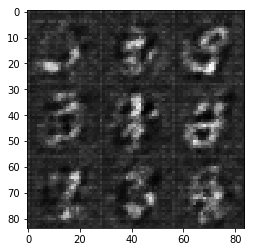

Epoch 1/2... Discriminator Loss: 2.3382... Generator Loss: 0.1914
Epoch 1/2... Discriminator Loss: 1.5946... Generator Loss: 0.7634
Epoch 1/2... Discriminator Loss: 2.0987... Generator Loss: 0.2022
Epoch 1/2... Discriminator Loss: 1.7867... Generator Loss: 0.3749
Epoch 1/2... Discriminator Loss: 2.7372... Generator Loss: 0.1116
Epoch 1/2... Discriminator Loss: 1.7171... Generator Loss: 0.3747
Epoch 1/2... Discriminator Loss: 2.1181... Generator Loss: 0.2171
Epoch 1/2... Discriminator Loss: 2.0396... Generator Loss: 0.2437
Epoch 1/2... Discriminator Loss: 1.1116... Generator Loss: 0.8410
Epoch 1/2... Discriminator Loss: 1.1474... Generator Loss: 0.9254


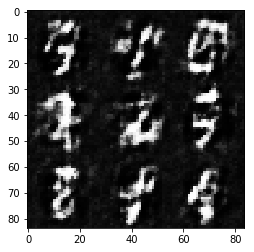

Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 1.1051
Epoch 1/2... Discriminator Loss: 1.4701... Generator Loss: 0.5166
Epoch 1/2... Discriminator Loss: 1.6465... Generator Loss: 0.3726
Epoch 1/2... Discriminator Loss: 1.4514... Generator Loss: 0.7147
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.8474
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 0.7396
Epoch 1/2... Discriminator Loss: 2.2118... Generator Loss: 0.2071
Epoch 1/2... Discriminator Loss: 1.2615... Generator Loss: 1.0999
Epoch 1/2... Discriminator Loss: 2.3057... Generator Loss: 0.1741
Epoch 1/2... Discriminator Loss: 2.3850... Generator Loss: 0.1682


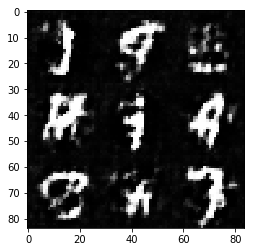

Epoch 1/2... Discriminator Loss: 1.3888... Generator Loss: 0.5957
Epoch 1/2... Discriminator Loss: 1.7142... Generator Loss: 0.3475
Epoch 1/2... Discriminator Loss: 1.3519... Generator Loss: 0.6191
Epoch 1/2... Discriminator Loss: 2.3261... Generator Loss: 0.1831
Epoch 1/2... Discriminator Loss: 2.1468... Generator Loss: 0.2364
Epoch 1/2... Discriminator Loss: 1.0042... Generator Loss: 1.0527
Epoch 1/2... Discriminator Loss: 2.3077... Generator Loss: 0.1838
Epoch 1/2... Discriminator Loss: 1.9157... Generator Loss: 0.2735
Epoch 1/2... Discriminator Loss: 1.4186... Generator Loss: 0.6073
Epoch 1/2... Discriminator Loss: 1.9639... Generator Loss: 0.2453


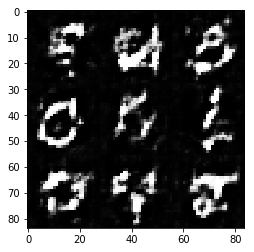

Epoch 1/2... Discriminator Loss: 1.2528... Generator Loss: 0.7667
Epoch 1/2... Discriminator Loss: 1.7866... Generator Loss: 0.3232
Epoch 1/2... Discriminator Loss: 2.4265... Generator Loss: 0.1784
Epoch 1/2... Discriminator Loss: 2.9901... Generator Loss: 0.0898
Epoch 1/2... Discriminator Loss: 2.2487... Generator Loss: 0.1934
Epoch 1/2... Discriminator Loss: 2.2329... Generator Loss: 0.2236
Epoch 1/2... Discriminator Loss: 1.3450... Generator Loss: 0.8226
Epoch 1/2... Discriminator Loss: 1.8281... Generator Loss: 0.3561
Epoch 1/2... Discriminator Loss: 1.8705... Generator Loss: 0.3055
Epoch 1/2... Discriminator Loss: 1.6517... Generator Loss: 0.3911


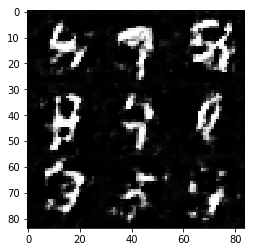

Epoch 1/2... Discriminator Loss: 1.7493... Generator Loss: 0.3763
Epoch 1/2... Discriminator Loss: 1.2006... Generator Loss: 1.2073
Epoch 1/2... Discriminator Loss: 1.4171... Generator Loss: 0.5344
Epoch 1/2... Discriminator Loss: 1.7690... Generator Loss: 0.3111
Epoch 1/2... Discriminator Loss: 1.9268... Generator Loss: 0.2421
Epoch 1/2... Discriminator Loss: 1.2664... Generator Loss: 0.6315
Epoch 1/2... Discriminator Loss: 1.9855... Generator Loss: 0.3038
Epoch 1/2... Discriminator Loss: 1.7850... Generator Loss: 0.3201
Epoch 1/2... Discriminator Loss: 1.2384... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 2.0422... Generator Loss: 0.2352


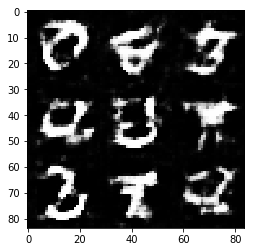

Epoch 1/2... Discriminator Loss: 2.2579... Generator Loss: 0.1951
Epoch 1/2... Discriminator Loss: 1.9009... Generator Loss: 0.3065
Epoch 1/2... Discriminator Loss: 1.8497... Generator Loss: 0.3271
Epoch 1/2... Discriminator Loss: 2.1390... Generator Loss: 0.2031
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.5395
Epoch 1/2... Discriminator Loss: 1.8027... Generator Loss: 0.3494
Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 3.2470
Epoch 1/2... Discriminator Loss: 1.3699... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 1.3464... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 1.9315... Generator Loss: 0.2565


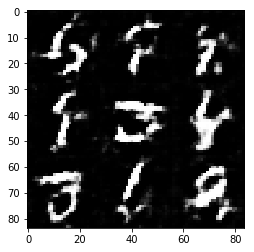

Epoch 1/2... Discriminator Loss: 1.5350... Generator Loss: 0.5140
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 0.7152
Epoch 1/2... Discriminator Loss: 0.8195... Generator Loss: 1.1833
Epoch 1/2... Discriminator Loss: 1.5024... Generator Loss: 0.5665
Epoch 1/2... Discriminator Loss: 1.8821... Generator Loss: 0.3103
Epoch 1/2... Discriminator Loss: 1.5489... Generator Loss: 0.4348
Epoch 1/2... Discriminator Loss: 1.6531... Generator Loss: 0.3747
Epoch 1/2... Discriminator Loss: 1.1813... Generator Loss: 0.7551
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.5267
Epoch 1/2... Discriminator Loss: 1.9443... Generator Loss: 0.2796


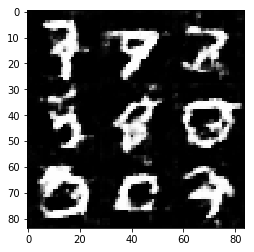

Epoch 1/2... Discriminator Loss: 1.5914... Generator Loss: 0.3960
Epoch 1/2... Discriminator Loss: 1.5521... Generator Loss: 0.4271
Epoch 1/2... Discriminator Loss: 1.4880... Generator Loss: 0.4762
Epoch 1/2... Discriminator Loss: 1.4058... Generator Loss: 0.5895
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 0.9435
Epoch 1/2... Discriminator Loss: 1.1801... Generator Loss: 0.6813
Epoch 1/2... Discriminator Loss: 1.4777... Generator Loss: 0.5261
Epoch 1/2... Discriminator Loss: 2.9445... Generator Loss: 0.1020
Epoch 1/2... Discriminator Loss: 1.4384... Generator Loss: 0.5320
Epoch 1/2... Discriminator Loss: 1.9146... Generator Loss: 0.2765


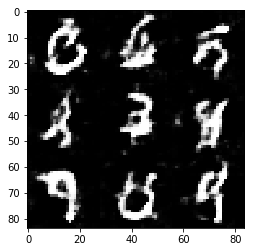

Epoch 1/2... Discriminator Loss: 1.2161... Generator Loss: 0.6757
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 0.9682
Epoch 1/2... Discriminator Loss: 1.2379... Generator Loss: 0.6047
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.6515
Epoch 1/2... Discriminator Loss: 1.3371... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 1.6496... Generator Loss: 0.3927
Epoch 1/2... Discriminator Loss: 1.4278... Generator Loss: 0.4734
Epoch 1/2... Discriminator Loss: 1.5098... Generator Loss: 0.4851
Epoch 1/2... Discriminator Loss: 1.3147... Generator Loss: 0.5709
Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.1123


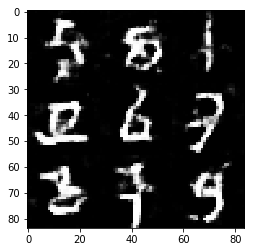

Epoch 1/2... Discriminator Loss: 1.7979... Generator Loss: 0.3342
Epoch 1/2... Discriminator Loss: 1.1738... Generator Loss: 0.6747
Epoch 1/2... Discriminator Loss: 1.5367... Generator Loss: 0.4158
Epoch 1/2... Discriminator Loss: 1.6448... Generator Loss: 0.4095
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.6717
Epoch 1/2... Discriminator Loss: 1.5694... Generator Loss: 0.3953
Epoch 1/2... Discriminator Loss: 1.2232... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.1687... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 0.9716... Generator Loss: 1.1656
Epoch 1/2... Discriminator Loss: 1.9008... Generator Loss: 0.3305


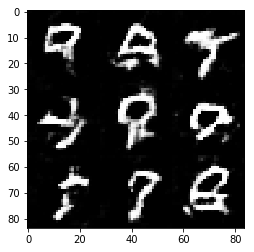

Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 0.6200
Epoch 1/2... Discriminator Loss: 1.2709... Generator Loss: 0.6869
Epoch 1/2... Discriminator Loss: 0.8259... Generator Loss: 1.1958
Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 1.2310
Epoch 1/2... Discriminator Loss: 1.4026... Generator Loss: 0.5146
Epoch 1/2... Discriminator Loss: 0.9950... Generator Loss: 0.8178
Epoch 1/2... Discriminator Loss: 0.7376... Generator Loss: 1.2017
Epoch 1/2... Discriminator Loss: 1.2848... Generator Loss: 0.5436
Epoch 1/2... Discriminator Loss: 0.6619... Generator Loss: 1.5207
Epoch 1/2... Discriminator Loss: 1.5762... Generator Loss: 0.3884


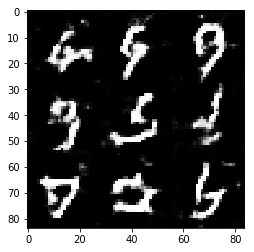

Epoch 1/2... Discriminator Loss: 0.8306... Generator Loss: 1.0639
Epoch 1/2... Discriminator Loss: 1.0392... Generator Loss: 0.8922
Epoch 1/2... Discriminator Loss: 1.7653... Generator Loss: 0.3141
Epoch 1/2... Discriminator Loss: 1.2772... Generator Loss: 0.6305
Epoch 1/2... Discriminator Loss: 2.1483... Generator Loss: 0.2368
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.5836
Epoch 1/2... Discriminator Loss: 1.6905... Generator Loss: 0.3435
Epoch 1/2... Discriminator Loss: 0.8762... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 1.4690... Generator Loss: 0.4387
Epoch 1/2... Discriminator Loss: 1.8359... Generator Loss: 0.4141


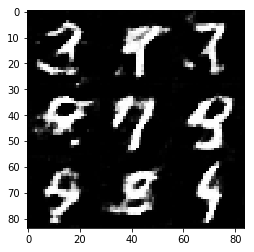

Epoch 1/2... Discriminator Loss: 1.7184... Generator Loss: 0.4071
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 0.6864... Generator Loss: 1.4136
Epoch 1/2... Discriminator Loss: 1.3050... Generator Loss: 0.5692
Epoch 1/2... Discriminator Loss: 1.9766... Generator Loss: 0.3334
Epoch 1/2... Discriminator Loss: 1.3444... Generator Loss: 0.6863
Epoch 1/2... Discriminator Loss: 1.0431... Generator Loss: 0.8293
Epoch 1/2... Discriminator Loss: 1.8803... Generator Loss: 0.2822
Epoch 1/2... Discriminator Loss: 2.1961... Generator Loss: 0.2686
Epoch 1/2... Discriminator Loss: 1.1821... Generator Loss: 0.6760


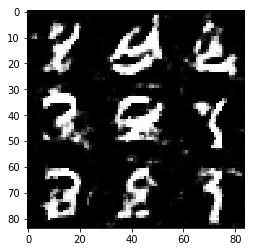

Epoch 1/2... Discriminator Loss: 1.5194... Generator Loss: 0.4146
Epoch 1/2... Discriminator Loss: 1.1482... Generator Loss: 0.8872
Epoch 1/2... Discriminator Loss: 1.5028... Generator Loss: 0.4506
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 1.1852... Generator Loss: 0.6831
Epoch 1/2... Discriminator Loss: 1.1246... Generator Loss: 0.9103
Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 0.4908
Epoch 1/2... Discriminator Loss: 1.6238... Generator Loss: 0.3831
Epoch 1/2... Discriminator Loss: 0.9802... Generator Loss: 0.8582
Epoch 1/2... Discriminator Loss: 1.6800... Generator Loss: 0.3480


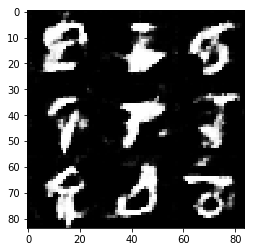

Epoch 1/2... Discriminator Loss: 1.7416... Generator Loss: 0.3712
Epoch 1/2... Discriminator Loss: 1.2284... Generator Loss: 0.7298
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.5100
Epoch 1/2... Discriminator Loss: 0.7682... Generator Loss: 1.2859
Epoch 1/2... Discriminator Loss: 0.8258... Generator Loss: 1.1919
Epoch 1/2... Discriminator Loss: 1.5547... Generator Loss: 0.4370
Epoch 1/2... Discriminator Loss: 1.1708... Generator Loss: 0.7679
Epoch 1/2... Discriminator Loss: 1.1403... Generator Loss: 0.6514
Epoch 1/2... Discriminator Loss: 1.5690... Generator Loss: 0.4203
Epoch 1/2... Discriminator Loss: 0.5723... Generator Loss: 1.8081


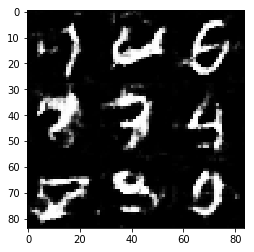

Epoch 1/2... Discriminator Loss: 1.9041... Generator Loss: 0.2945
Epoch 1/2... Discriminator Loss: 0.9492... Generator Loss: 0.9074
Epoch 1/2... Discriminator Loss: 0.9122... Generator Loss: 1.0917
Epoch 1/2... Discriminator Loss: 0.9816... Generator Loss: 0.8278
Epoch 1/2... Discriminator Loss: 1.0679... Generator Loss: 0.8279
Epoch 1/2... Discriminator Loss: 0.9233... Generator Loss: 0.9006
Epoch 1/2... Discriminator Loss: 1.2438... Generator Loss: 0.8347
Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 1.1236
Epoch 1/2... Discriminator Loss: 0.8979... Generator Loss: 1.0777
Epoch 1/2... Discriminator Loss: 1.0741... Generator Loss: 0.8801


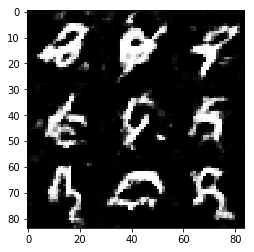

Epoch 1/2... Discriminator Loss: 0.6057... Generator Loss: 1.8732
Epoch 1/2... Discriminator Loss: 1.3102... Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 0.9235... Generator Loss: 1.1208
Epoch 1/2... Discriminator Loss: 0.9561... Generator Loss: 1.2886
Epoch 1/2... Discriminator Loss: 0.8158... Generator Loss: 1.4031
Epoch 1/2... Discriminator Loss: 1.4739... Generator Loss: 0.5142
Epoch 1/2... Discriminator Loss: 0.9374... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.0016... Generator Loss: 0.8971
Epoch 1/2... Discriminator Loss: 0.8453... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 1.6427... Generator Loss: 0.4193


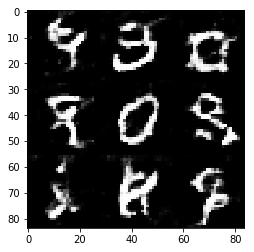

Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.4951
Epoch 1/2... Discriminator Loss: 1.3564... Generator Loss: 0.5056
Epoch 1/2... Discriminator Loss: 1.2342... Generator Loss: 0.6909
Epoch 1/2... Discriminator Loss: 0.7845... Generator Loss: 1.3315
Epoch 1/2... Discriminator Loss: 1.2287... Generator Loss: 0.5963
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 0.7255... Generator Loss: 1.3823
Epoch 2/2... Discriminator Loss: 0.9190... Generator Loss: 0.9356
Epoch 2/2... Discriminator Loss: 0.8024... Generator Loss: 1.1332
Epoch 2/2... Discriminator Loss: 0.8536... Generator Loss: 1.0385


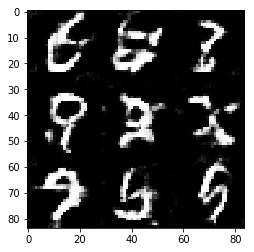

Epoch 2/2... Discriminator Loss: 1.2824... Generator Loss: 0.5638
Epoch 2/2... Discriminator Loss: 0.5816... Generator Loss: 1.8997
Epoch 2/2... Discriminator Loss: 1.1010... Generator Loss: 0.7471
Epoch 2/2... Discriminator Loss: 0.6339... Generator Loss: 1.6879
Epoch 2/2... Discriminator Loss: 0.8966... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 0.8082... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 1.2426... Generator Loss: 0.7036
Epoch 2/2... Discriminator Loss: 1.4185... Generator Loss: 0.4560
Epoch 2/2... Discriminator Loss: 1.0177... Generator Loss: 0.8090
Epoch 2/2... Discriminator Loss: 1.1680... Generator Loss: 0.6613


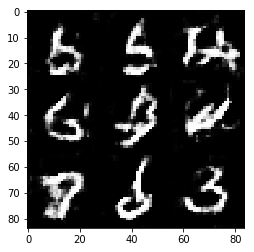

Epoch 2/2... Discriminator Loss: 1.0566... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 1.0538... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 0.8962... Generator Loss: 0.9411
Epoch 2/2... Discriminator Loss: 0.7429... Generator Loss: 1.2511
Epoch 2/2... Discriminator Loss: 0.4741... Generator Loss: 2.2608
Epoch 2/2... Discriminator Loss: 0.6121... Generator Loss: 1.6932
Epoch 2/2... Discriminator Loss: 0.6825... Generator Loss: 1.3430
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.9512
Epoch 2/2... Discriminator Loss: 0.7854... Generator Loss: 1.0874
Epoch 2/2... Discriminator Loss: 0.5466... Generator Loss: 1.9040


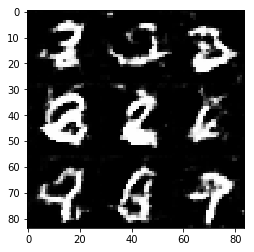

Epoch 2/2... Discriminator Loss: 0.7044... Generator Loss: 1.3961
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 0.9486
Epoch 2/2... Discriminator Loss: 0.9939... Generator Loss: 0.8370
Epoch 2/2... Discriminator Loss: 0.6995... Generator Loss: 1.3134
Epoch 2/2... Discriminator Loss: 0.5769... Generator Loss: 1.6401
Epoch 2/2... Discriminator Loss: 2.1918... Generator Loss: 0.2503
Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 0.6659
Epoch 2/2... Discriminator Loss: 0.9399... Generator Loss: 0.9280
Epoch 2/2... Discriminator Loss: 0.8060... Generator Loss: 1.2090
Epoch 2/2... Discriminator Loss: 0.7017... Generator Loss: 1.3188


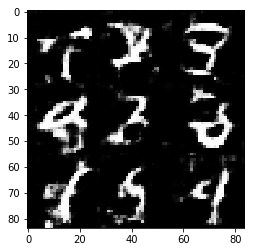

Epoch 2/2... Discriminator Loss: 2.6592... Generator Loss: 0.2759
Epoch 2/2... Discriminator Loss: 1.7385... Generator Loss: 0.2941
Epoch 2/2... Discriminator Loss: 0.4204... Generator Loss: 3.3580
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.0999
Epoch 2/2... Discriminator Loss: 0.5160... Generator Loss: 1.8876
Epoch 2/2... Discriminator Loss: 1.1001... Generator Loss: 0.7905
Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 0.9789... Generator Loss: 0.8594
Epoch 2/2... Discriminator Loss: 0.8870... Generator Loss: 0.9647
Epoch 2/2... Discriminator Loss: 0.8492... Generator Loss: 1.2260


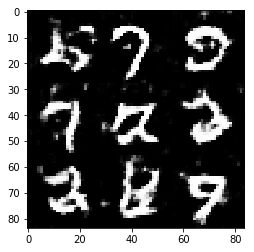

Epoch 2/2... Discriminator Loss: 0.8304... Generator Loss: 1.1613
Epoch 2/2... Discriminator Loss: 1.1364... Generator Loss: 0.7394
Epoch 2/2... Discriminator Loss: 1.2423... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 1.3563... Generator Loss: 0.5635
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 0.9747
Epoch 2/2... Discriminator Loss: 0.6333... Generator Loss: 1.4803
Epoch 2/2... Discriminator Loss: 1.0964... Generator Loss: 0.7350
Epoch 2/2... Discriminator Loss: 1.2262... Generator Loss: 0.6290
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.7343
Epoch 2/2... Discriminator Loss: 1.4997... Generator Loss: 0.5440


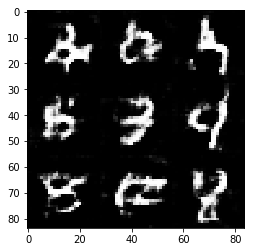

Epoch 2/2... Discriminator Loss: 0.4883... Generator Loss: 2.0928
Epoch 2/2... Discriminator Loss: 0.6254... Generator Loss: 1.4475
Epoch 2/2... Discriminator Loss: 2.3803... Generator Loss: 0.2142
Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 1.2076
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 1.2648
Epoch 2/2... Discriminator Loss: 1.6519... Generator Loss: 0.3821
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 1.7309
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 1.3189
Epoch 2/2... Discriminator Loss: 1.3734... Generator Loss: 0.4680
Epoch 2/2... Discriminator Loss: 0.5213... Generator Loss: 1.9969


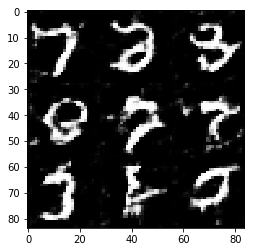

Epoch 2/2... Discriminator Loss: 0.8766... Generator Loss: 0.9982
Epoch 2/2... Discriminator Loss: 0.9028... Generator Loss: 0.9059
Epoch 2/2... Discriminator Loss: 1.0190... Generator Loss: 0.7904
Epoch 2/2... Discriminator Loss: 1.2207... Generator Loss: 0.6377
Epoch 2/2... Discriminator Loss: 0.8318... Generator Loss: 1.3856
Epoch 2/2... Discriminator Loss: 0.7534... Generator Loss: 1.1834
Epoch 2/2... Discriminator Loss: 1.1271... Generator Loss: 0.6635
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 1.4191
Epoch 2/2... Discriminator Loss: 1.2035... Generator Loss: 0.6823
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.0246


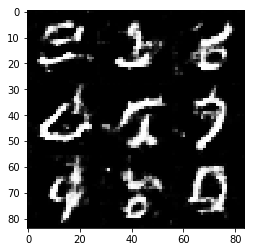

Epoch 2/2... Discriminator Loss: 0.8734... Generator Loss: 1.3450
Epoch 2/2... Discriminator Loss: 1.7844... Generator Loss: 0.4014
Epoch 2/2... Discriminator Loss: 1.5317... Generator Loss: 0.4488
Epoch 2/2... Discriminator Loss: 1.9115... Generator Loss: 0.3907
Epoch 2/2... Discriminator Loss: 0.6030... Generator Loss: 1.6256
Epoch 2/2... Discriminator Loss: 0.6506... Generator Loss: 1.3905
Epoch 2/2... Discriminator Loss: 1.2063... Generator Loss: 0.6942
Epoch 2/2... Discriminator Loss: 1.0511... Generator Loss: 0.8776
Epoch 2/2... Discriminator Loss: 1.1753... Generator Loss: 0.6721
Epoch 2/2... Discriminator Loss: 0.8744... Generator Loss: 1.0197


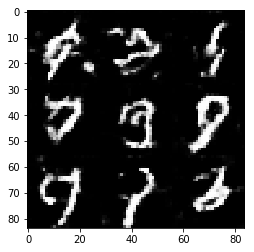

Epoch 2/2... Discriminator Loss: 0.8876... Generator Loss: 1.0420
Epoch 2/2... Discriminator Loss: 1.4831... Generator Loss: 0.4004
Epoch 2/2... Discriminator Loss: 1.2119... Generator Loss: 0.5898
Epoch 2/2... Discriminator Loss: 1.0396... Generator Loss: 0.7810
Epoch 2/2... Discriminator Loss: 0.8564... Generator Loss: 1.0162
Epoch 2/2... Discriminator Loss: 1.4581... Generator Loss: 0.4413
Epoch 2/2... Discriminator Loss: 0.7811... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 1.9140... Generator Loss: 0.2480
Epoch 2/2... Discriminator Loss: 0.9721... Generator Loss: 0.7961
Epoch 2/2... Discriminator Loss: 0.6522... Generator Loss: 1.5949


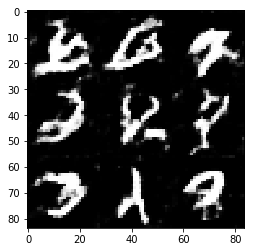

Epoch 2/2... Discriminator Loss: 0.5987... Generator Loss: 1.6368
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 1.0366
Epoch 2/2... Discriminator Loss: 0.7824... Generator Loss: 1.0719
Epoch 2/2... Discriminator Loss: 1.5715... Generator Loss: 0.4030
Epoch 2/2... Discriminator Loss: 0.8043... Generator Loss: 1.0215
Epoch 2/2... Discriminator Loss: 1.3466... Generator Loss: 0.5900
Epoch 2/2... Discriminator Loss: 0.7469... Generator Loss: 1.1552
Epoch 2/2... Discriminator Loss: 0.8323... Generator Loss: 0.9946
Epoch 2/2... Discriminator Loss: 1.0050... Generator Loss: 0.7554
Epoch 2/2... Discriminator Loss: 0.7914... Generator Loss: 1.0775


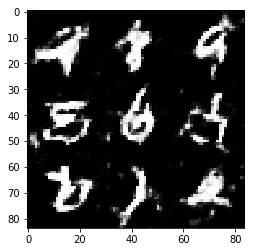

Epoch 2/2... Discriminator Loss: 0.5176... Generator Loss: 1.8456
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 0.8049
Epoch 2/2... Discriminator Loss: 0.7207... Generator Loss: 1.2757
Epoch 2/2... Discriminator Loss: 1.3503... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 0.4308... Generator Loss: 2.8582
Epoch 2/2... Discriminator Loss: 0.6333... Generator Loss: 1.4889
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 0.9068
Epoch 2/2... Discriminator Loss: 0.9933... Generator Loss: 0.8516
Epoch 2/2... Discriminator Loss: 1.1087... Generator Loss: 0.7212
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 0.9509


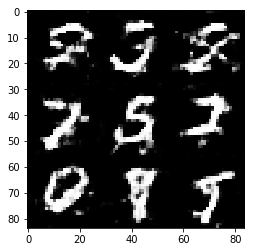

Epoch 2/2... Discriminator Loss: 0.6407... Generator Loss: 1.5716
Epoch 2/2... Discriminator Loss: 0.7255... Generator Loss: 1.3415
Epoch 2/2... Discriminator Loss: 0.6184... Generator Loss: 1.7345
Epoch 2/2... Discriminator Loss: 1.2803... Generator Loss: 0.5559
Epoch 2/2... Discriminator Loss: 1.4677... Generator Loss: 0.4957
Epoch 2/2... Discriminator Loss: 0.7769... Generator Loss: 1.0497
Epoch 2/2... Discriminator Loss: 0.8432... Generator Loss: 1.0903
Epoch 2/2... Discriminator Loss: 0.7516... Generator Loss: 1.1822
Epoch 2/2... Discriminator Loss: 0.9321... Generator Loss: 0.8256
Epoch 2/2... Discriminator Loss: 0.4416... Generator Loss: 2.4862


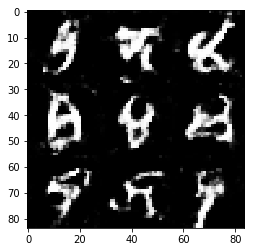

Epoch 2/2... Discriminator Loss: 0.9742... Generator Loss: 0.8204
Epoch 2/2... Discriminator Loss: 1.2117... Generator Loss: 0.6158
Epoch 2/2... Discriminator Loss: 1.3043... Generator Loss: 0.5656
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 0.9359
Epoch 2/2... Discriminator Loss: 1.1942... Generator Loss: 0.6559
Epoch 2/2... Discriminator Loss: 1.2021... Generator Loss: 0.6194
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 0.7308
Epoch 2/2... Discriminator Loss: 0.5919... Generator Loss: 1.6367
Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 1.7600


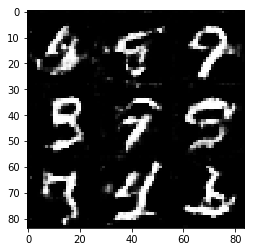

Epoch 2/2... Discriminator Loss: 0.8826... Generator Loss: 1.0062
Epoch 2/2... Discriminator Loss: 0.4793... Generator Loss: 2.2494
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 1.2491... Generator Loss: 0.6156
Epoch 2/2... Discriminator Loss: 0.7128... Generator Loss: 1.3431
Epoch 2/2... Discriminator Loss: 1.0091... Generator Loss: 0.7639
Epoch 2/2... Discriminator Loss: 1.0258... Generator Loss: 0.8387
Epoch 2/2... Discriminator Loss: 1.0821... Generator Loss: 0.7213
Epoch 2/2... Discriminator Loss: 1.3206... Generator Loss: 0.5028


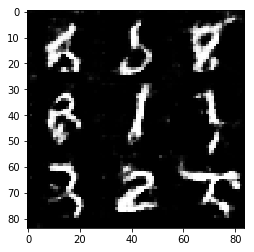

Epoch 2/2... Discriminator Loss: 0.6529... Generator Loss: 1.4566
Epoch 2/2... Discriminator Loss: 0.8361... Generator Loss: 0.9900
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.9235
Epoch 2/2... Discriminator Loss: 0.7708... Generator Loss: 1.1031
Epoch 2/2... Discriminator Loss: 0.9189... Generator Loss: 0.9788
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 0.8402
Epoch 2/2... Discriminator Loss: 1.0097... Generator Loss: 0.7496
Epoch 2/2... Discriminator Loss: 0.5326... Generator Loss: 1.8120
Epoch 2/2... Discriminator Loss: 0.8015... Generator Loss: 1.0469
Epoch 2/2... Discriminator Loss: 1.0594... Generator Loss: 0.7886


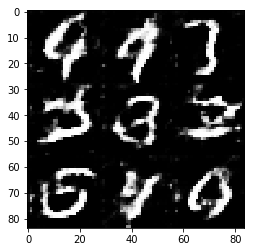

Epoch 2/2... Discriminator Loss: 0.5842... Generator Loss: 1.7779
Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.4117
Epoch 2/2... Discriminator Loss: 0.6213... Generator Loss: 1.5004
Epoch 2/2... Discriminator Loss: 0.7562... Generator Loss: 1.1723
Epoch 2/2... Discriminator Loss: 0.3801... Generator Loss: 3.2312
Epoch 2/2... Discriminator Loss: 0.6349... Generator Loss: 1.4507
Epoch 2/2... Discriminator Loss: 0.5464... Generator Loss: 1.8551
Epoch 2/2... Discriminator Loss: 1.2787... Generator Loss: 0.6327
Epoch 2/2... Discriminator Loss: 0.8199... Generator Loss: 1.1671
Epoch 2/2... Discriminator Loss: 1.0716... Generator Loss: 0.8275


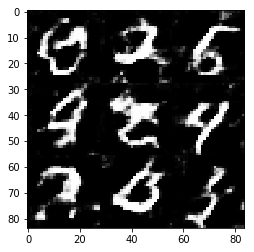

Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.0484
Epoch 2/2... Discriminator Loss: 0.6301... Generator Loss: 1.5694
Epoch 2/2... Discriminator Loss: 1.0631... Generator Loss: 0.7495
Epoch 2/2... Discriminator Loss: 0.4442... Generator Loss: 2.5930
Epoch 2/2... Discriminator Loss: 0.5285... Generator Loss: 1.8766
Epoch 2/2... Discriminator Loss: 0.7407... Generator Loss: 1.2863
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 0.9286
Epoch 2/2... Discriminator Loss: 0.6314... Generator Loss: 1.5469
Epoch 2/2... Discriminator Loss: 0.8110... Generator Loss: 1.3702
Epoch 2/2... Discriminator Loss: 0.4585... Generator Loss: 2.2454


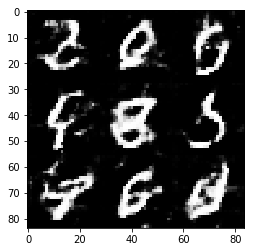

Epoch 2/2... Discriminator Loss: 0.6671... Generator Loss: 1.3254
Epoch 2/2... Discriminator Loss: 0.6950... Generator Loss: 1.4193
Epoch 2/2... Discriminator Loss: 0.6658... Generator Loss: 1.4004
Epoch 2/2... Discriminator Loss: 0.5864... Generator Loss: 1.5362
Epoch 2/2... Discriminator Loss: 0.4484... Generator Loss: 2.3305
Epoch 2/2... Discriminator Loss: 0.3881... Generator Loss: 3.0553
Epoch 2/2... Discriminator Loss: 0.4303... Generator Loss: 2.6062
Epoch 2/2... Discriminator Loss: 0.5068... Generator Loss: 2.1511
Epoch 2/2... Discriminator Loss: 0.4706... Generator Loss: 2.1594
Epoch 2/2... Discriminator Loss: 0.6241... Generator Loss: 1.6340


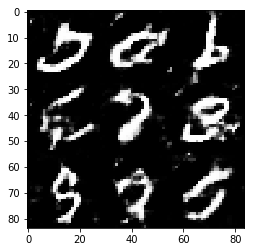

Epoch 2/2... Discriminator Loss: 0.6801... Generator Loss: 1.3407
Epoch 2/2... Discriminator Loss: 1.6572... Generator Loss: 0.4094
Epoch 2/2... Discriminator Loss: 0.5659... Generator Loss: 1.7105
Epoch 2/2... Discriminator Loss: 0.7473... Generator Loss: 1.3170
Epoch 2/2... Discriminator Loss: 0.7284... Generator Loss: 1.3079


In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5




"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 5.3604... Generator Loss: 0.0081
Epoch 1/1... Discriminator Loss: 5.5910... Generator Loss: 0.0067
Epoch 1/1... Discriminator Loss: 3.9741... Generator Loss: 0.0434
Epoch 1/1... Discriminator Loss: 3.6612... Generator Loss: 0.0451
Epoch 1/1... Discriminator Loss: 3.0477... Generator Loss: 0.0857
Epoch 1/1... Discriminator Loss: 2.5253... Generator Loss: 0.1516
Epoch 1/1... Discriminator Loss: 2.6096... Generator Loss: 0.1376
Epoch 1/1... Discriminator Loss: 2.2771... Generator Loss: 0.2210
Epoch 1/1... Discriminator Loss: 2.7945... Generator Loss: 0.1144
Epoch 1/1... Discriminator Loss: 2.6050... Generator Loss: 0.1457


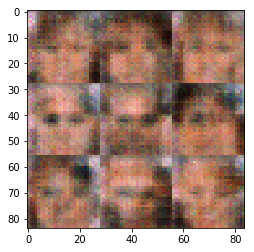

Epoch 1/1... Discriminator Loss: 3.0762... Generator Loss: 0.0903
Epoch 1/1... Discriminator Loss: 3.9222... Generator Loss: 0.0343
Epoch 1/1... Discriminator Loss: 2.5968... Generator Loss: 0.1546
Epoch 1/1... Discriminator Loss: 3.1998... Generator Loss: 0.0651
Epoch 1/1... Discriminator Loss: 2.4074... Generator Loss: 0.3280
Epoch 1/1... Discriminator Loss: 2.6432... Generator Loss: 0.1334
Epoch 1/1... Discriminator Loss: 2.8643... Generator Loss: 0.0966
Epoch 1/1... Discriminator Loss: 2.8399... Generator Loss: 0.1232
Epoch 1/1... Discriminator Loss: 2.4194... Generator Loss: 0.3420
Epoch 1/1... Discriminator Loss: 3.1234... Generator Loss: 0.1121


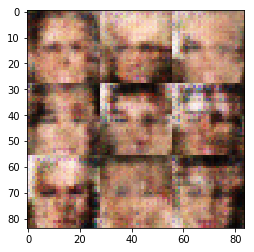

Epoch 1/1... Discriminator Loss: 2.4091... Generator Loss: 0.1638
Epoch 1/1... Discriminator Loss: 3.6681... Generator Loss: 0.0602
Epoch 1/1... Discriminator Loss: 2.6949... Generator Loss: 0.1211
Epoch 1/1... Discriminator Loss: 2.8066... Generator Loss: 0.1064
Epoch 1/1... Discriminator Loss: 2.5001... Generator Loss: 0.1973
Epoch 1/1... Discriminator Loss: 1.9601... Generator Loss: 0.2916
Epoch 1/1... Discriminator Loss: 3.9380... Generator Loss: 0.0362
Epoch 1/1... Discriminator Loss: 2.7842... Generator Loss: 0.1182
Epoch 1/1... Discriminator Loss: 2.8870... Generator Loss: 0.1194
Epoch 1/1... Discriminator Loss: 3.6709... Generator Loss: 0.0553


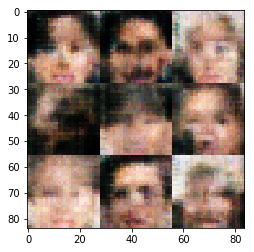

Epoch 1/1... Discriminator Loss: 2.6303... Generator Loss: 0.1307
Epoch 1/1... Discriminator Loss: 3.1418... Generator Loss: 0.0756
Epoch 1/1... Discriminator Loss: 3.2622... Generator Loss: 0.0705
Epoch 1/1... Discriminator Loss: 1.8821... Generator Loss: 0.3900
Epoch 1/1... Discriminator Loss: 2.3800... Generator Loss: 0.1507
Epoch 1/1... Discriminator Loss: 2.2543... Generator Loss: 0.1950
Epoch 1/1... Discriminator Loss: 2.6032... Generator Loss: 0.1270
Epoch 1/1... Discriminator Loss: 3.2865... Generator Loss: 0.0643
Epoch 1/1... Discriminator Loss: 2.2165... Generator Loss: 0.3572
Epoch 1/1... Discriminator Loss: 2.2536... Generator Loss: 0.1785


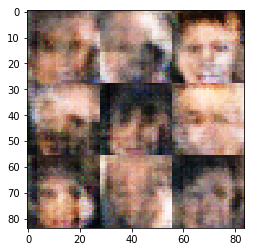

Epoch 1/1... Discriminator Loss: 3.4985... Generator Loss: 0.0535
Epoch 1/1... Discriminator Loss: 3.1292... Generator Loss: 0.0938
Epoch 1/1... Discriminator Loss: 2.3505... Generator Loss: 0.1757
Epoch 1/1... Discriminator Loss: 1.8017... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 3.5747... Generator Loss: 0.0577
Epoch 1/1... Discriminator Loss: 2.5807... Generator Loss: 0.1663
Epoch 1/1... Discriminator Loss: 2.8828... Generator Loss: 0.1048
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 1.2389
Epoch 1/1... Discriminator Loss: 2.3880... Generator Loss: 0.1971
Epoch 1/1... Discriminator Loss: 2.3867... Generator Loss: 0.1994


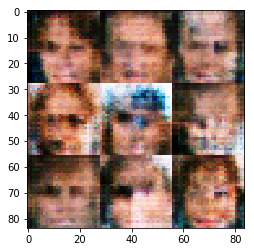

Epoch 1/1... Discriminator Loss: 2.6914... Generator Loss: 0.1168
Epoch 1/1... Discriminator Loss: 3.8764... Generator Loss: 0.0411
Epoch 1/1... Discriminator Loss: 2.2004... Generator Loss: 0.2057
Epoch 1/1... Discriminator Loss: 2.6628... Generator Loss: 0.1254
Epoch 1/1... Discriminator Loss: 1.9386... Generator Loss: 0.3130
Epoch 1/1... Discriminator Loss: 2.3496... Generator Loss: 0.1888
Epoch 1/1... Discriminator Loss: 2.7849... Generator Loss: 0.1048
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 2.5811... Generator Loss: 0.1192
Epoch 1/1... Discriminator Loss: 2.7593... Generator Loss: 0.1190


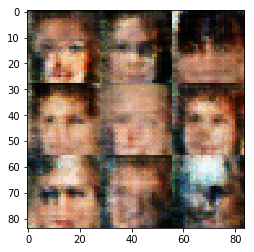

Epoch 1/1... Discriminator Loss: 2.6460... Generator Loss: 0.1389
Epoch 1/1... Discriminator Loss: 2.3793... Generator Loss: 0.1961
Epoch 1/1... Discriminator Loss: 3.3103... Generator Loss: 0.0700
Epoch 1/1... Discriminator Loss: 3.0107... Generator Loss: 0.0789
Epoch 1/1... Discriminator Loss: 2.4798... Generator Loss: 0.1456
Epoch 1/1... Discriminator Loss: 2.2865... Generator Loss: 0.2050
Epoch 1/1... Discriminator Loss: 2.4730... Generator Loss: 0.1653
Epoch 1/1... Discriminator Loss: 2.2607... Generator Loss: 0.2659
Epoch 1/1... Discriminator Loss: 1.6870... Generator Loss: 0.3962
Epoch 1/1... Discriminator Loss: 2.7455... Generator Loss: 0.1076


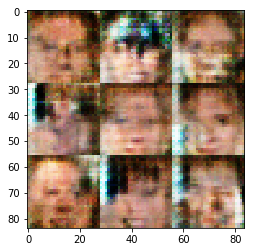

Epoch 1/1... Discriminator Loss: 1.8573... Generator Loss: 0.2818
Epoch 1/1... Discriminator Loss: 2.3601... Generator Loss: 0.1641
Epoch 1/1... Discriminator Loss: 2.0289... Generator Loss: 0.2920
Epoch 1/1... Discriminator Loss: 2.4580... Generator Loss: 0.1646
Epoch 1/1... Discriminator Loss: 2.0893... Generator Loss: 0.2227
Epoch 1/1... Discriminator Loss: 0.5824... Generator Loss: 1.8142
Epoch 1/1... Discriminator Loss: 1.5947... Generator Loss: 0.4164
Epoch 1/1... Discriminator Loss: 2.4298... Generator Loss: 0.1682
Epoch 1/1... Discriminator Loss: 1.9585... Generator Loss: 0.3377
Epoch 1/1... Discriminator Loss: 2.7681... Generator Loss: 0.1097


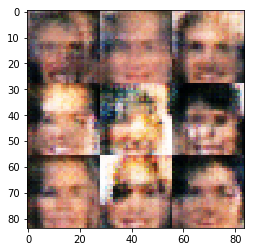

Epoch 1/1... Discriminator Loss: 2.6894... Generator Loss: 0.1149
Epoch 1/1... Discriminator Loss: 1.8645... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 2.5863... Generator Loss: 0.1883
Epoch 1/1... Discriminator Loss: 1.8340... Generator Loss: 0.3320
Epoch 1/1... Discriminator Loss: 1.5757... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.9777... Generator Loss: 0.2947
Epoch 1/1... Discriminator Loss: 2.3658... Generator Loss: 0.2137
Epoch 1/1... Discriminator Loss: 2.7785... Generator Loss: 0.1164
Epoch 1/1... Discriminator Loss: 2.6272... Generator Loss: 0.1329


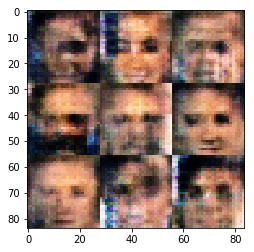

Epoch 1/1... Discriminator Loss: 1.7859... Generator Loss: 0.4313
Epoch 1/1... Discriminator Loss: 1.6683... Generator Loss: 0.3386
Epoch 1/1... Discriminator Loss: 2.4199... Generator Loss: 0.1817
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 2.3781... Generator Loss: 0.1645
Epoch 1/1... Discriminator Loss: 2.8801... Generator Loss: 0.0937
Epoch 1/1... Discriminator Loss: 1.7782... Generator Loss: 0.3627
Epoch 1/1... Discriminator Loss: 1.2749... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.7870... Generator Loss: 0.4429
Epoch 1/1... Discriminator Loss: 0.7933... Generator Loss: 1.1632


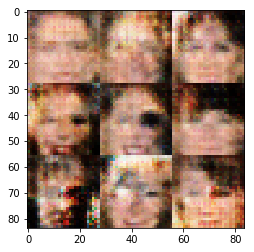

Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.1493... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 0.8148... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 2.3857... Generator Loss: 0.1513
Epoch 1/1... Discriminator Loss: 1.0612... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 2.8690... Generator Loss: 0.1070
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 2.5420... Generator Loss: 0.2160


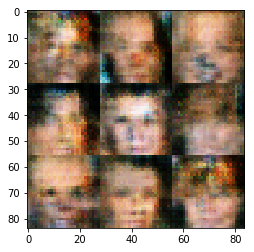

Epoch 1/1... Discriminator Loss: 0.7396... Generator Loss: 1.5208
Epoch 1/1... Discriminator Loss: 1.6300... Generator Loss: 0.3697
Epoch 1/1... Discriminator Loss: 0.5500... Generator Loss: 1.7274
Epoch 1/1... Discriminator Loss: 2.7999... Generator Loss: 0.1064
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.7935
Epoch 1/1... Discriminator Loss: 1.4393... Generator Loss: 0.6260
Epoch 1/1... Discriminator Loss: 1.8118... Generator Loss: 0.3367
Epoch 1/1... Discriminator Loss: 2.2152... Generator Loss: 0.2074


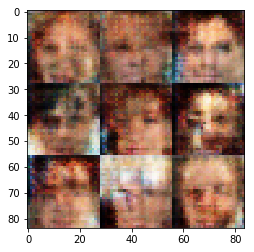

Epoch 1/1... Discriminator Loss: 1.8599... Generator Loss: 0.3892
Epoch 1/1... Discriminator Loss: 2.2993... Generator Loss: 0.1794
Epoch 1/1... Discriminator Loss: 1.2732... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.5723... Generator Loss: 0.4039
Epoch 1/1... Discriminator Loss: 2.4131... Generator Loss: 0.1558
Epoch 1/1... Discriminator Loss: 1.3663... Generator Loss: 0.5272
Epoch 1/1... Discriminator Loss: 1.0318... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 0.7386... Generator Loss: 1.2694
Epoch 1/1... Discriminator Loss: 0.6154... Generator Loss: 1.5712
Epoch 1/1... Discriminator Loss: 0.9565... Generator Loss: 0.9751


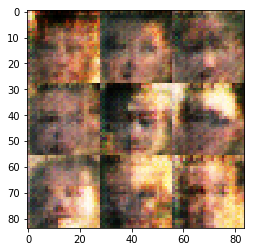

Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 2.6292... Generator Loss: 0.1189
Epoch 1/1... Discriminator Loss: 1.6620... Generator Loss: 0.3585
Epoch 1/1... Discriminator Loss: 2.3374... Generator Loss: 0.1910
Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.8208... Generator Loss: 0.2919
Epoch 1/1... Discriminator Loss: 1.6832... Generator Loss: 0.3301
Epoch 1/1... Discriminator Loss: 1.6231... Generator Loss: 0.4387
Epoch 1/1... Discriminator Loss: 1.0338... Generator Loss: 1.0566
Epoch 1/1... Discriminator Loss: 0.5117... Generator Loss: 2.0112


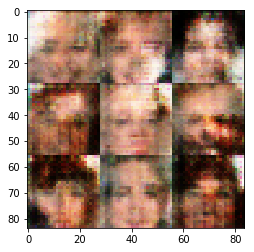

Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.6653
Epoch 1/1... Discriminator Loss: 0.9528... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 3.2010... Generator Loss: 0.0845
Epoch 1/1... Discriminator Loss: 1.6093... Generator Loss: 0.3638
Epoch 1/1... Discriminator Loss: 1.7393... Generator Loss: 0.3115
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.1630... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 0.6801... Generator Loss: 1.4297
Epoch 1/1... Discriminator Loss: 0.5693... Generator Loss: 1.8572
Epoch 1/1... Discriminator Loss: 0.6624... Generator Loss: 1.3710


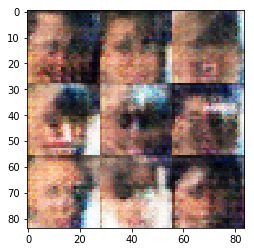

Epoch 1/1... Discriminator Loss: 1.3474... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 0.6997... Generator Loss: 1.6360
Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.0077
Epoch 1/1... Discriminator Loss: 1.5054... Generator Loss: 0.4121
Epoch 1/1... Discriminator Loss: 3.4581... Generator Loss: 0.0623
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.8139... Generator Loss: 0.4366
Epoch 1/1... Discriminator Loss: 2.7312... Generator Loss: 0.1145
Epoch 1/1... Discriminator Loss: 1.7281... Generator Loss: 0.3178
Epoch 1/1... Discriminator Loss: 2.1987... Generator Loss: 0.2109


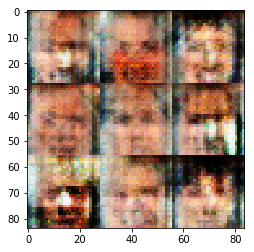

Epoch 1/1... Discriminator Loss: 1.9975... Generator Loss: 0.2572
Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 0.9727
Epoch 1/1... Discriminator Loss: 0.8441... Generator Loss: 1.1284
Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.1059
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.6817
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.6636... Generator Loss: 0.3350
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.4863
Epoch 1/1... Discriminator Loss: 0.5357... Generator Loss: 1.9649
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.7331


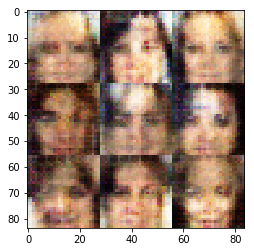

Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 0.8534
Epoch 1/1... Discriminator Loss: 0.9001... Generator Loss: 0.9987
Epoch 1/1... Discriminator Loss: 0.9173... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 0.4889... Generator Loss: 2.0983
Epoch 1/1... Discriminator Loss: 0.6295... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 0.4605... Generator Loss: 2.3896
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.8092... Generator Loss: 0.3006
Epoch 1/1... Discriminator Loss: 2.1364... Generator Loss: 0.2116
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.7451


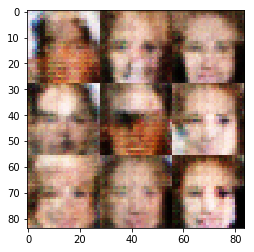

Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 0.3872
Epoch 1/1... Discriminator Loss: 1.4091... Generator Loss: 0.5648
Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.5722
Epoch 1/1... Discriminator Loss: 0.9963... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.8970... Generator Loss: 0.2632
Epoch 1/1... Discriminator Loss: 0.7779... Generator Loss: 1.6110
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 0.8214... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 0.5966... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.5102


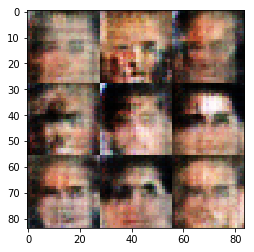

Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 0.5945
Epoch 1/1... Discriminator Loss: 1.6625... Generator Loss: 0.3592
Epoch 1/1... Discriminator Loss: 2.4582... Generator Loss: 0.1599
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 0.7910... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 3.7510
Epoch 1/1... Discriminator Loss: 0.9583... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.3215
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 0.9031... Generator Loss: 1.0514


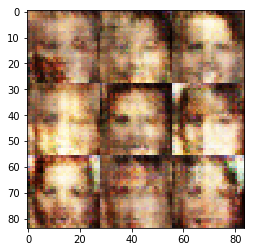

Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.4408
Epoch 1/1... Discriminator Loss: 0.4464... Generator Loss: 2.6824
Epoch 1/1... Discriminator Loss: 0.7104... Generator Loss: 1.3352
Epoch 1/1... Discriminator Loss: 1.6085... Generator Loss: 0.3752
Epoch 1/1... Discriminator Loss: 1.9241... Generator Loss: 0.2776
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.5899
Epoch 1/1... Discriminator Loss: 0.6065... Generator Loss: 1.6334
Epoch 1/1... Discriminator Loss: 1.1298... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 2.4654


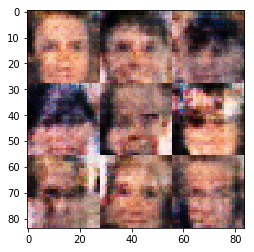

Epoch 1/1... Discriminator Loss: 1.1114... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 0.8723... Generator Loss: 0.9928
Epoch 1/1... Discriminator Loss: 0.7776... Generator Loss: 1.1103
Epoch 1/1... Discriminator Loss: 0.5899... Generator Loss: 3.0102
Epoch 1/1... Discriminator Loss: 1.0426... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 0.5613... Generator Loss: 2.0905
Epoch 1/1... Discriminator Loss: 0.7962... Generator Loss: 1.1693
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.4825
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 2.0784


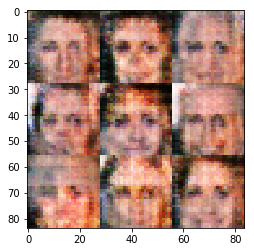

Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 1.1830
Epoch 1/1... Discriminator Loss: 0.5688... Generator Loss: 2.0394
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.5185
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.8501
Epoch 1/1... Discriminator Loss: 0.4783... Generator Loss: 2.2707
Epoch 1/1... Discriminator Loss: 0.4588... Generator Loss: 2.3554
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 3.1843
Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.3741
Epoch 1/1... Discriminator Loss: 0.7963... Generator Loss: 1.0520


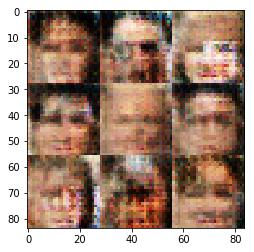

Epoch 1/1... Discriminator Loss: 0.7718... Generator Loss: 1.2126
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 1.7765
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 2.5778
Epoch 1/1... Discriminator Loss: 0.3975... Generator Loss: 3.1006
Epoch 1/1... Discriminator Loss: 0.8017... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 0.5988... Generator Loss: 1.7479
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 0.6547... Generator Loss: 1.5734
Epoch 1/1... Discriminator Loss: 0.6200... Generator Loss: 1.5680


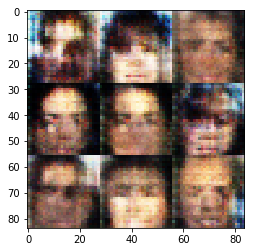

Epoch 1/1... Discriminator Loss: 0.8673... Generator Loss: 0.9503
Epoch 1/1... Discriminator Loss: 1.1128... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.0153... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 0.7506... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 1.4079
Epoch 1/1... Discriminator Loss: 2.0416... Generator Loss: 0.2595


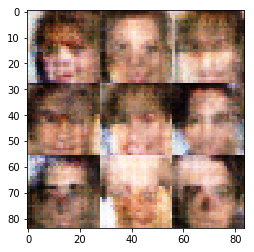

Epoch 1/1... Discriminator Loss: 0.6346... Generator Loss: 1.5988
Epoch 1/1... Discriminator Loss: 1.0526... Generator Loss: 0.9244
Epoch 1/1... Discriminator Loss: 1.6177... Generator Loss: 0.4100
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.0085... Generator Loss: 0.8355
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.0103... Generator Loss: 0.8659
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.5472... Generator Loss: 0.5211


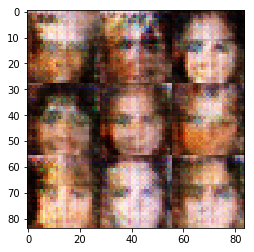

Epoch 1/1... Discriminator Loss: 0.5750... Generator Loss: 1.7190
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.6530
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 0.8980
Epoch 1/1... Discriminator Loss: 0.4364... Generator Loss: 2.6062
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.4573
Epoch 1/1... Discriminator Loss: 0.4671... Generator Loss: 2.2905
Epoch 1/1... Discriminator Loss: 0.8663... Generator Loss: 0.9688
Epoch 1/1... Discriminator Loss: 0.8606... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 0.6486... Generator Loss: 1.5031
Epoch 1/1... Discriminator Loss: 1.1447... Generator Loss: 0.6605


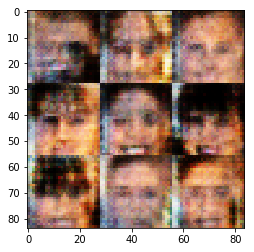

Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.5576
Epoch 1/1... Discriminator Loss: 1.9420... Generator Loss: 0.2444
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.0115... Generator Loss: 0.8703
Epoch 1/1... Discriminator Loss: 0.8814... Generator Loss: 0.9321
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 1.6934
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.3702
Epoch 1/1... Discriminator Loss: 0.6046... Generator Loss: 1.6168


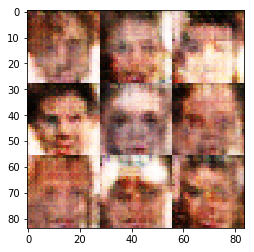

Epoch 1/1... Discriminator Loss: 0.4480... Generator Loss: 2.4142
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.1149
Epoch 1/1... Discriminator Loss: 0.5990... Generator Loss: 1.5717
Epoch 1/1... Discriminator Loss: 0.7228... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 0.4489... Generator Loss: 2.9340
Epoch 1/1... Discriminator Loss: 1.5844... Generator Loss: 0.3971
Epoch 1/1... Discriminator Loss: 0.6229... Generator Loss: 1.7433
Epoch 1/1... Discriminator Loss: 0.6040... Generator Loss: 1.7454
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.6207


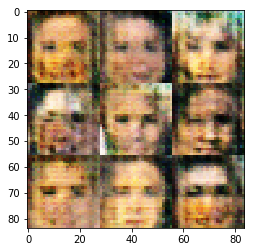

Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 0.6009... Generator Loss: 1.6110
Epoch 1/1... Discriminator Loss: 0.4842... Generator Loss: 2.1453
Epoch 1/1... Discriminator Loss: 0.5876... Generator Loss: 1.5878
Epoch 1/1... Discriminator Loss: 0.8985... Generator Loss: 0.9416
Epoch 1/1... Discriminator Loss: 0.5505... Generator Loss: 1.7757
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 0.9023
Epoch 1/1... Discriminator Loss: 0.5996... Generator Loss: 1.7620
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.5525


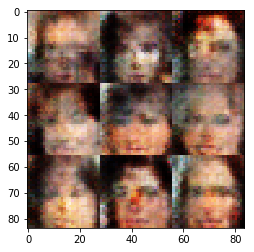

Epoch 1/1... Discriminator Loss: 0.6804... Generator Loss: 1.3102
Epoch 1/1... Discriminator Loss: 0.8192... Generator Loss: 1.1619
Epoch 1/1... Discriminator Loss: 0.7838... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 0.7524... Generator Loss: 1.1623
Epoch 1/1... Discriminator Loss: 0.5049... Generator Loss: 2.0222
Epoch 1/1... Discriminator Loss: 0.4026... Generator Loss: 2.8209
Epoch 1/1... Discriminator Loss: 0.4090... Generator Loss: 2.9106
Epoch 1/1... Discriminator Loss: 0.4664... Generator Loss: 2.2541
Epoch 1/1... Discriminator Loss: 0.7881... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 0.5510... Generator Loss: 1.7262


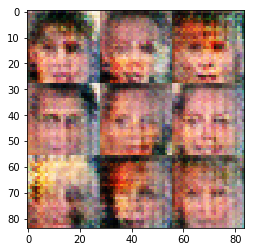

Epoch 1/1... Discriminator Loss: 0.6323... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 0.4071... Generator Loss: 4.6258
Epoch 1/1... Discriminator Loss: 0.8204... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 0.6865... Generator Loss: 1.3728
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.4457
Epoch 1/1... Discriminator Loss: 0.5230... Generator Loss: 2.0362
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 0.8803
Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 1.3138
Epoch 1/1... Discriminator Loss: 1.1623... Generator Loss: 0.6191
Epoch 1/1... Discriminator Loss: 0.9028... Generator Loss: 0.9785


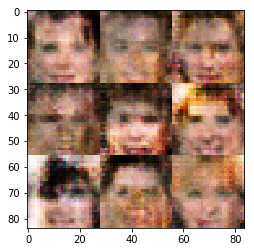

Epoch 1/1... Discriminator Loss: 0.6117... Generator Loss: 1.5504
Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.6365
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 0.5619... Generator Loss: 1.9277
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 0.7312... Generator Loss: 1.3204
Epoch 1/1... Discriminator Loss: 0.4950... Generator Loss: 2.1832
Epoch 1/1... Discriminator Loss: 1.0604... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 0.4322... Generator Loss: 2.9662
Epoch 1/1... Discriminator Loss: 0.4012... Generator Loss: 2.7363


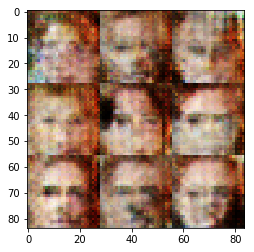

Epoch 1/1... Discriminator Loss: 0.3572... Generator Loss: 3.9361
Epoch 1/1... Discriminator Loss: 0.4661... Generator Loss: 2.3382
Epoch 1/1... Discriminator Loss: 0.4136... Generator Loss: 2.7778
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.6713
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.5216
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.3103
Epoch 1/1... Discriminator Loss: 0.3553... Generator Loss: 3.9614
Epoch 1/1... Discriminator Loss: 0.3892... Generator Loss: 3.1280
Epoch 1/1... Discriminator Loss: 0.3755... Generator Loss: 3.6093
Epoch 1/1... Discriminator Loss: 0.3600... Generator Loss: 3.8908


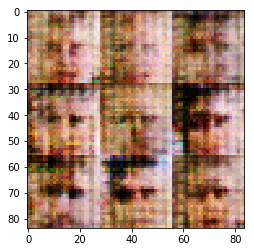

Epoch 1/1... Discriminator Loss: 0.3895... Generator Loss: 3.0838
Epoch 1/1... Discriminator Loss: 0.4740... Generator Loss: 2.1306
Epoch 1/1... Discriminator Loss: 0.6266... Generator Loss: 1.4736
Epoch 1/1... Discriminator Loss: 0.7477... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 0.4865... Generator Loss: 2.3802
Epoch 1/1... Discriminator Loss: 0.6648... Generator Loss: 1.4361
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 0.7611... Generator Loss: 1.2652
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 3.7242
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.2852


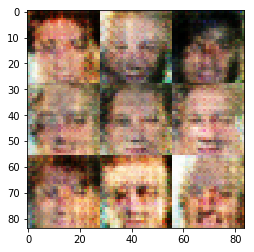

Epoch 1/1... Discriminator Loss: 0.7119... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 0.6007... Generator Loss: 1.5901
Epoch 1/1... Discriminator Loss: 0.6887... Generator Loss: 1.3189
Epoch 1/1... Discriminator Loss: 0.5977... Generator Loss: 1.6695
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 0.8675... Generator Loss: 1.1034
Epoch 1/1... Discriminator Loss: 1.1551... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.0891
Epoch 1/1... Discriminator Loss: 1.0090... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 0.5121... Generator Loss: 2.0536


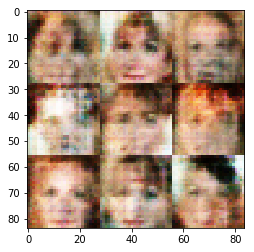

Epoch 1/1... Discriminator Loss: 0.4742... Generator Loss: 2.2575
Epoch 1/1... Discriminator Loss: 0.3557... Generator Loss: 3.8361
Epoch 1/1... Discriminator Loss: 0.5777... Generator Loss: 1.6770
Epoch 1/1... Discriminator Loss: 0.6152... Generator Loss: 1.6583
Epoch 1/1... Discriminator Loss: 0.3507... Generator Loss: 5.1185
Epoch 1/1... Discriminator Loss: 0.8226... Generator Loss: 1.1010
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 1.5258
Epoch 1/1... Discriminator Loss: 0.7767... Generator Loss: 1.2575
Epoch 1/1... Discriminator Loss: 0.4863... Generator Loss: 2.0346
Epoch 1/1... Discriminator Loss: 1.0421... Generator Loss: 0.6971


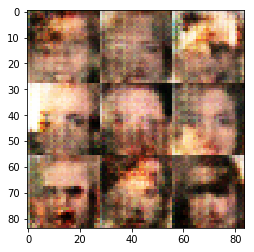

Epoch 1/1... Discriminator Loss: 0.5013... Generator Loss: 1.9688
Epoch 1/1... Discriminator Loss: 0.3674... Generator Loss: 3.6310
Epoch 1/1... Discriminator Loss: 0.4244... Generator Loss: 2.5331
Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 4.1182
Epoch 1/1... Discriminator Loss: 0.3500... Generator Loss: 4.0199
Epoch 1/1... Discriminator Loss: 0.4055... Generator Loss: 2.9191
Epoch 1/1... Discriminator Loss: 0.3474... Generator Loss: 4.5628
Epoch 1/1... Discriminator Loss: 0.4900... Generator Loss: 2.0670
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.0693
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.7332


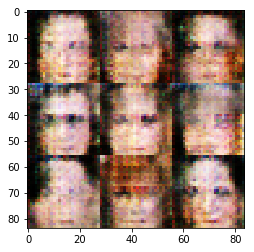

Epoch 1/1... Discriminator Loss: 0.5819... Generator Loss: 1.6436
Epoch 1/1... Discriminator Loss: 0.4073... Generator Loss: 2.7102
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 2.8925
Epoch 1/1... Discriminator Loss: 0.3936... Generator Loss: 2.9315
Epoch 1/1... Discriminator Loss: 0.6985... Generator Loss: 1.3087
Epoch 1/1... Discriminator Loss: 0.7814... Generator Loss: 1.1219
Epoch 1/1... Discriminator Loss: 0.6600... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 0.3842... Generator Loss: 3.1574
Epoch 1/1... Discriminator Loss: 0.9455... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 0.4786... Generator Loss: 2.1176


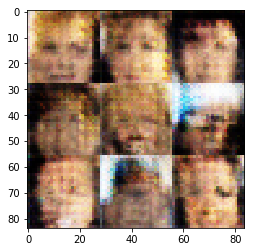

Epoch 1/1... Discriminator Loss: 0.4096... Generator Loss: 2.8693
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 2.7362
Epoch 1/1... Discriminator Loss: 0.7820... Generator Loss: 1.1071
Epoch 1/1... Discriminator Loss: 0.7884... Generator Loss: 1.2291
Epoch 1/1... Discriminator Loss: 0.7247... Generator Loss: 1.2550
Epoch 1/1... Discriminator Loss: 1.0007... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 2.0433... Generator Loss: 0.2601
Epoch 1/1... Discriminator Loss: 0.5353... Generator Loss: 1.9199
Epoch 1/1... Discriminator Loss: 1.1014... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 0.5489... Generator Loss: 1.7396


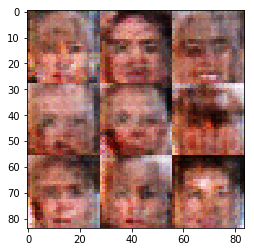

Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 1.4590
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 1.3497
Epoch 1/1... Discriminator Loss: 0.5072... Generator Loss: 1.9599
Epoch 1/1... Discriminator Loss: 0.4870... Generator Loss: 2.1059
Epoch 1/1... Discriminator Loss: 0.6253... Generator Loss: 1.4342
Epoch 1/1... Discriminator Loss: 0.5548... Generator Loss: 1.7665
Epoch 1/1... Discriminator Loss: 0.3529... Generator Loss: 4.0275
Epoch 1/1... Discriminator Loss: 0.8521... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 2.8803


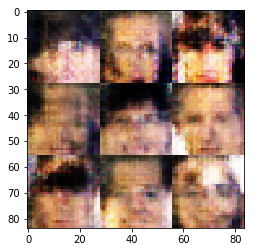

Epoch 1/1... Discriminator Loss: 0.6396... Generator Loss: 1.6687
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 0.5815... Generator Loss: 1.8123
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 1.4159
Epoch 1/1... Discriminator Loss: 0.4000... Generator Loss: 2.9685
Epoch 1/1... Discriminator Loss: 0.5457... Generator Loss: 1.8065
Epoch 1/1... Discriminator Loss: 0.4919... Generator Loss: 1.9742
Epoch 1/1... Discriminator Loss: 0.3850... Generator Loss: 3.5099
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 1.5676
Epoch 1/1... Discriminator Loss: 0.4011... Generator Loss: 4.0591


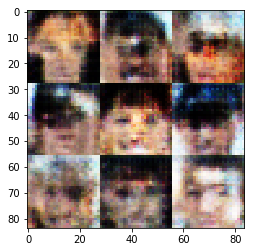

Epoch 1/1... Discriminator Loss: 0.9550... Generator Loss: 0.9788
Epoch 1/1... Discriminator Loss: 0.6099... Generator Loss: 1.5067
Epoch 1/1... Discriminator Loss: 0.4864... Generator Loss: 2.4898
Epoch 1/1... Discriminator Loss: 1.0425... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 0.9229... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.1683... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 0.7955... Generator Loss: 1.1057
Epoch 1/1... Discriminator Loss: 0.6710... Generator Loss: 1.4217
Epoch 1/1... Discriminator Loss: 0.7459... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 0.4733... Generator Loss: 2.1785


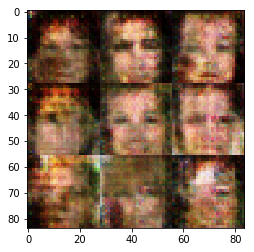

Epoch 1/1... Discriminator Loss: 0.6366... Generator Loss: 1.5146
Epoch 1/1... Discriminator Loss: 0.8967... Generator Loss: 0.9071
Epoch 1/1... Discriminator Loss: 0.9602... Generator Loss: 0.8451
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 0.9717
Epoch 1/1... Discriminator Loss: 0.5113... Generator Loss: 1.8645
Epoch 1/1... Discriminator Loss: 0.4057... Generator Loss: 2.7804
Epoch 1/1... Discriminator Loss: 0.5261... Generator Loss: 1.9262
Epoch 1/1... Discriminator Loss: 0.7949... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 0.7487... Generator Loss: 1.2217


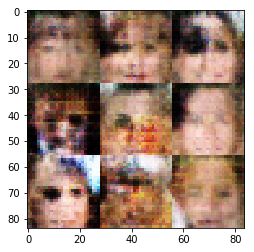

Epoch 1/1... Discriminator Loss: 0.6355... Generator Loss: 1.4284
Epoch 1/1... Discriminator Loss: 0.8902... Generator Loss: 0.9815
Epoch 1/1... Discriminator Loss: 0.6967... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 0.4630... Generator Loss: 2.2657
Epoch 1/1... Discriminator Loss: 0.6335... Generator Loss: 1.5375
Epoch 1/1... Discriminator Loss: 0.5765... Generator Loss: 1.7672
Epoch 1/1... Discriminator Loss: 0.5717... Generator Loss: 1.7201
Epoch 1/1... Discriminator Loss: 0.3503... Generator Loss: 4.1869
Epoch 1/1... Discriminator Loss: 0.5891... Generator Loss: 1.5758
Epoch 1/1... Discriminator Loss: 0.9806... Generator Loss: 0.7989


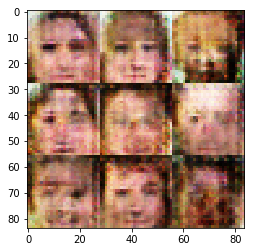

Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.0902
Epoch 1/1... Discriminator Loss: 0.3590... Generator Loss: 5.1083
Epoch 1/1... Discriminator Loss: 0.5330... Generator Loss: 1.9627
Epoch 1/1... Discriminator Loss: 0.4167... Generator Loss: 3.0798
Epoch 1/1... Discriminator Loss: 0.4479... Generator Loss: 2.4514
Epoch 1/1... Discriminator Loss: 0.4579... Generator Loss: 2.4091
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.7375
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 2.7552
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 1.8473
Epoch 1/1... Discriminator Loss: 0.6662... Generator Loss: 1.3735


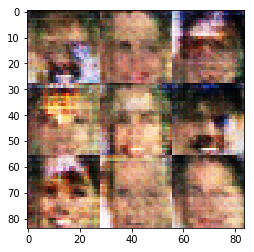

Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 1.7545
Epoch 1/1... Discriminator Loss: 0.4034... Generator Loss: 3.2313
Epoch 1/1... Discriminator Loss: 0.3964... Generator Loss: 3.0075
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 0.3765... Generator Loss: 3.6334
Epoch 1/1... Discriminator Loss: 0.3893... Generator Loss: 3.0644
Epoch 1/1... Discriminator Loss: 0.5321... Generator Loss: 1.7814
Epoch 1/1... Discriminator Loss: 0.4773... Generator Loss: 2.1430
Epoch 1/1... Discriminator Loss: 0.4624... Generator Loss: 2.3157
Epoch 1/1... Discriminator Loss: 0.4684... Generator Loss: 2.3192


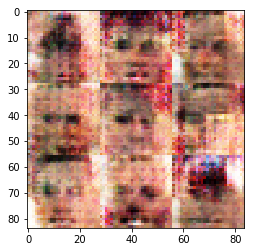

Epoch 1/1... Discriminator Loss: 0.3830... Generator Loss: 3.0994
Epoch 1/1... Discriminator Loss: 0.3528... Generator Loss: 5.1204
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 3.8005
Epoch 1/1... Discriminator Loss: 0.3820... Generator Loss: 3.2152
Epoch 1/1... Discriminator Loss: 0.4058... Generator Loss: 3.0707
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 1.2952
Epoch 1/1... Discriminator Loss: 0.4215... Generator Loss: 2.8897
Epoch 1/1... Discriminator Loss: 0.9851... Generator Loss: 1.0435
Epoch 1/1... Discriminator Loss: 0.5034... Generator Loss: 2.1878
Epoch 1/1... Discriminator Loss: 0.6632... Generator Loss: 1.4721


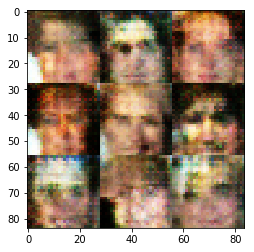

Epoch 1/1... Discriminator Loss: 0.4980... Generator Loss: 2.0139
Epoch 1/1... Discriminator Loss: 0.5689... Generator Loss: 1.6179
Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 2.0452
Epoch 1/1... Discriminator Loss: 0.4548... Generator Loss: 2.2016
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 2.1558
Epoch 1/1... Discriminator Loss: 0.8418... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 0.8312... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 0.5277... Generator Loss: 1.8998
Epoch 1/1... Discriminator Loss: 0.5021... Generator Loss: 2.0355
Epoch 1/1... Discriminator Loss: 0.4291... Generator Loss: 2.6135


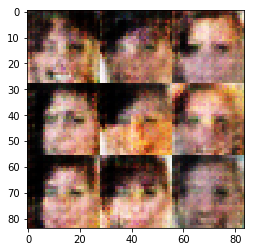

Epoch 1/1... Discriminator Loss: 1.0130... Generator Loss: 0.8681
Epoch 1/1... Discriminator Loss: 0.7282... Generator Loss: 1.1976
Epoch 1/1... Discriminator Loss: 0.3638... Generator Loss: 4.1138
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 2.1435
Epoch 1/1... Discriminator Loss: 0.4909... Generator Loss: 2.3632
Epoch 1/1... Discriminator Loss: 0.4879... Generator Loss: 2.4081
Epoch 1/1... Discriminator Loss: 0.6760... Generator Loss: 1.3994
Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.5519
Epoch 1/1... Discriminator Loss: 0.4685... Generator Loss: 2.1411
Epoch 1/1... Discriminator Loss: 0.8725... Generator Loss: 0.9564


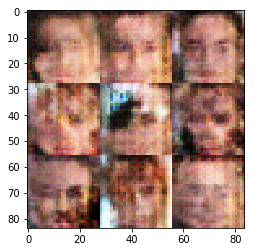

Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 0.4151... Generator Loss: 2.5825
Epoch 1/1... Discriminator Loss: 0.6418... Generator Loss: 1.4787
Epoch 1/1... Discriminator Loss: 0.5288... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 0.7565... Generator Loss: 1.1052
Epoch 1/1... Discriminator Loss: 0.4936... Generator Loss: 2.0234
Epoch 1/1... Discriminator Loss: 0.4113... Generator Loss: 2.8619
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 1.4434
Epoch 1/1... Discriminator Loss: 0.4064... Generator Loss: 2.7859
Epoch 1/1... Discriminator Loss: 0.3531... Generator Loss: 4.0071


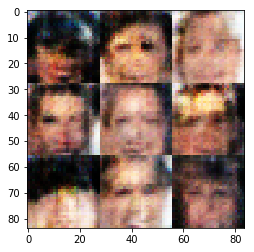

Epoch 1/1... Discriminator Loss: 0.7451... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 0.3462... Generator Loss: 5.3294
Epoch 1/1... Discriminator Loss: 0.3399... Generator Loss: 5.1085
Epoch 1/1... Discriminator Loss: 0.5149... Generator Loss: 1.9544
Epoch 1/1... Discriminator Loss: 0.5560... Generator Loss: 1.7544
Epoch 1/1... Discriminator Loss: 0.5464... Generator Loss: 1.6982
Epoch 1/1... Discriminator Loss: 0.3493... Generator Loss: 4.2043
Epoch 1/1... Discriminator Loss: 0.4366... Generator Loss: 2.4936
Epoch 1/1... Discriminator Loss: 0.7892... Generator Loss: 1.2302


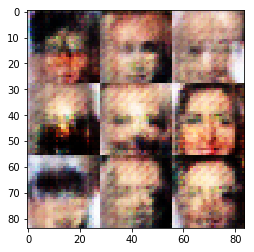

Epoch 1/1... Discriminator Loss: 0.7576... Generator Loss: 1.1082
Epoch 1/1... Discriminator Loss: 0.9503... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 2.4014
Epoch 1/1... Discriminator Loss: 0.5224... Generator Loss: 1.9449
Epoch 1/1... Discriminator Loss: 1.6841... Generator Loss: 0.3587
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.5088
Epoch 1/1... Discriminator Loss: 0.5721... Generator Loss: 1.6860
Epoch 1/1... Discriminator Loss: 0.4072... Generator Loss: 2.8910
Epoch 1/1... Discriminator Loss: 1.1793... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 0.6677... Generator Loss: 1.4362


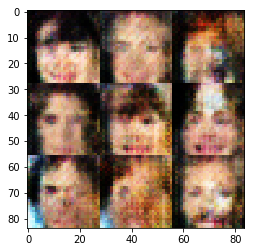

Epoch 1/1... Discriminator Loss: 0.4799... Generator Loss: 2.1695
Epoch 1/1... Discriminator Loss: 0.4640... Generator Loss: 2.2139
Epoch 1/1... Discriminator Loss: 0.3889... Generator Loss: 3.1212
Epoch 1/1... Discriminator Loss: 0.5737... Generator Loss: 1.5842
Epoch 1/1... Discriminator Loss: 0.4668... Generator Loss: 2.1570
Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.9518
Epoch 1/1... Discriminator Loss: 0.6720... Generator Loss: 1.4040
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.1109
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 2.7971
Epoch 1/1... Discriminator Loss: 0.4201... Generator Loss: 2.6843


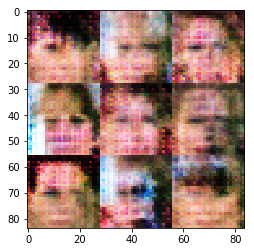

Epoch 1/1... Discriminator Loss: 0.4744... Generator Loss: 2.2081
Epoch 1/1... Discriminator Loss: 0.4593... Generator Loss: 2.4258
Epoch 1/1... Discriminator Loss: 0.3641... Generator Loss: 3.6967
Epoch 1/1... Discriminator Loss: 0.3700... Generator Loss: 3.4552
Epoch 1/1... Discriminator Loss: 0.4408... Generator Loss: 2.6742
Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 1.1676
Epoch 1/1... Discriminator Loss: 0.7833... Generator Loss: 1.1546
Epoch 1/1... Discriminator Loss: 0.5803... Generator Loss: 1.6057
Epoch 1/1... Discriminator Loss: 0.7364... Generator Loss: 1.1453
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 2.8618


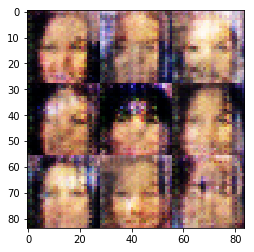

Epoch 1/1... Discriminator Loss: 0.5445... Generator Loss: 1.7274
Epoch 1/1... Discriminator Loss: 0.5096... Generator Loss: 1.9665
Epoch 1/1... Discriminator Loss: 0.5481... Generator Loss: 1.7500
Epoch 1/1... Discriminator Loss: 0.7122... Generator Loss: 1.6821
Epoch 1/1... Discriminator Loss: 0.9333... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 0.9006... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 0.5484... Generator Loss: 1.7835
Epoch 1/1... Discriminator Loss: 0.6051... Generator Loss: 1.6959
Epoch 1/1... Discriminator Loss: 0.4828... Generator Loss: 2.1501
Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 2.1539


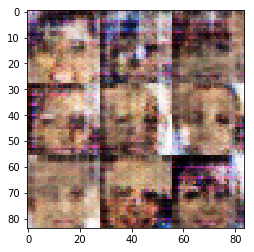

Epoch 1/1... Discriminator Loss: 0.4353... Generator Loss: 2.6767
Epoch 1/1... Discriminator Loss: 0.3592... Generator Loss: 3.6914
Epoch 1/1... Discriminator Loss: 0.5270... Generator Loss: 1.9251
Epoch 1/1... Discriminator Loss: 0.4925... Generator Loss: 1.9800
Epoch 1/1... Discriminator Loss: 0.3865... Generator Loss: 3.0867
Epoch 1/1... Discriminator Loss: 0.7590... Generator Loss: 1.2364
Epoch 1/1... Discriminator Loss: 0.6041... Generator Loss: 1.5651
Epoch 1/1... Discriminator Loss: 0.6510... Generator Loss: 1.4607
Epoch 1/1... Discriminator Loss: 0.5244... Generator Loss: 1.8362
Epoch 1/1... Discriminator Loss: 0.9691... Generator Loss: 1.0369


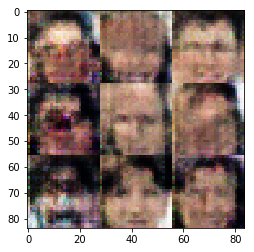

Epoch 1/1... Discriminator Loss: 0.8143... Generator Loss: 1.2386
Epoch 1/1... Discriminator Loss: 0.4354... Generator Loss: 2.6904
Epoch 1/1... Discriminator Loss: 0.3506... Generator Loss: 4.5782
Epoch 1/1... Discriminator Loss: 0.3478... Generator Loss: 4.3496
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 1.0711
Epoch 1/1... Discriminator Loss: 0.9355... Generator Loss: 2.1961
Epoch 1/1... Discriminator Loss: 0.6213... Generator Loss: 1.6524
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 1.7635
Epoch 1/1... Discriminator Loss: 0.7343... Generator Loss: 1.4550
Epoch 1/1... Discriminator Loss: 0.4867... Generator Loss: 2.1712


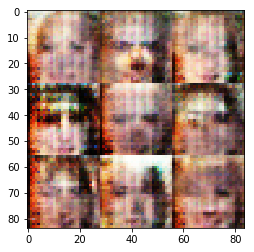

Epoch 1/1... Discriminator Loss: 0.3993... Generator Loss: 3.0458
Epoch 1/1... Discriminator Loss: 0.3411... Generator Loss: 5.0897
Epoch 1/1... Discriminator Loss: 0.4638... Generator Loss: 2.1962
Epoch 1/1... Discriminator Loss: 0.4540... Generator Loss: 2.4582
Epoch 1/1... Discriminator Loss: 0.4187... Generator Loss: 2.6849
Epoch 1/1... Discriminator Loss: 0.4176... Generator Loss: 2.6617
Epoch 1/1... Discriminator Loss: 0.3568... Generator Loss: 3.8180
Epoch 1/1... Discriminator Loss: 0.3803... Generator Loss: 3.1830
Epoch 1/1... Discriminator Loss: 0.3922... Generator Loss: 2.9917
Epoch 1/1... Discriminator Loss: 0.4895... Generator Loss: 2.0116


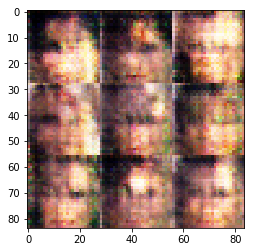

Epoch 1/1... Discriminator Loss: 0.7618... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 0.6462... Generator Loss: 1.3987
Epoch 1/1... Discriminator Loss: 0.4899... Generator Loss: 2.3668
Epoch 1/1... Discriminator Loss: 0.3781... Generator Loss: 3.2626
Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 4.0607
Epoch 1/1... Discriminator Loss: 0.5924... Generator Loss: 1.6662
Epoch 1/1... Discriminator Loss: 0.4175... Generator Loss: 2.6493
Epoch 1/1... Discriminator Loss: 0.4506... Generator Loss: 2.2504
Epoch 1/1... Discriminator Loss: 0.5104... Generator Loss: 2.0628
Epoch 1/1... Discriminator Loss: 0.4040... Generator Loss: 2.8170


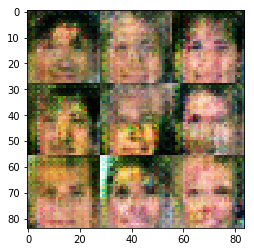

Epoch 1/1... Discriminator Loss: 0.4985... Generator Loss: 2.0634
Epoch 1/1... Discriminator Loss: 0.9062... Generator Loss: 0.8519
Epoch 1/1... Discriminator Loss: 0.4801... Generator Loss: 2.3570
Epoch 1/1... Discriminator Loss: 0.8224... Generator Loss: 0.9659
Epoch 1/1... Discriminator Loss: 0.3862... Generator Loss: 3.0510
Epoch 1/1... Discriminator Loss: 0.5083... Generator Loss: 1.8463
Epoch 1/1... Discriminator Loss: 0.8318... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 0.4031... Generator Loss: 2.7611
Epoch 1/1... Discriminator Loss: 0.5060... Generator Loss: 2.0361
Epoch 1/1... Discriminator Loss: 0.6970... Generator Loss: 1.2829


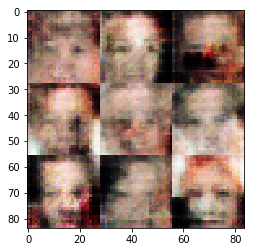

Epoch 1/1... Discriminator Loss: 0.3488... Generator Loss: 4.2607
Epoch 1/1... Discriminator Loss: 0.3741... Generator Loss: 3.2948
Epoch 1/1... Discriminator Loss: 0.4186... Generator Loss: 2.7039
Epoch 1/1... Discriminator Loss: 0.3923... Generator Loss: 2.9240
Epoch 1/1... Discriminator Loss: 0.5304... Generator Loss: 1.7874
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.1473
Epoch 1/1... Discriminator Loss: 0.7537... Generator Loss: 1.3154
Epoch 1/1... Discriminator Loss: 0.4404... Generator Loss: 4.5913
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.4159
Epoch 1/1... Discriminator Loss: 0.4226... Generator Loss: 2.5880


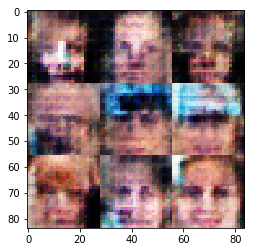

Epoch 1/1... Discriminator Loss: 0.4006... Generator Loss: 3.2167
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 4.0515
Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 2.8804
Epoch 1/1... Discriminator Loss: 0.4146... Generator Loss: 2.7100
Epoch 1/1... Discriminator Loss: 0.5323... Generator Loss: 1.8628
Epoch 1/1... Discriminator Loss: 0.5675... Generator Loss: 1.8038
Epoch 1/1... Discriminator Loss: 0.4522... Generator Loss: 2.3586
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 2.3852
Epoch 1/1... Discriminator Loss: 0.5116... Generator Loss: 2.1848
Epoch 1/1... Discriminator Loss: 0.4898... Generator Loss: 2.0529


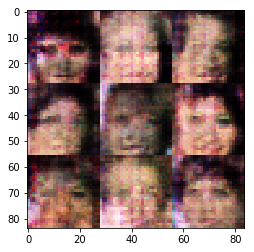

Epoch 1/1... Discriminator Loss: 0.5264... Generator Loss: 1.8223
Epoch 1/1... Discriminator Loss: 0.5627... Generator Loss: 1.7870
Epoch 1/1... Discriminator Loss: 0.3878... Generator Loss: 3.1501


In [13]:
#batch_size = 100
#z_dim = 10
#learning_rate = 0.0001
#beta1 = 0.5
batch_size = 32
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.